In [1]:
import config as cfg
import pandas as pd 
import geopandas as gpd
import numpy as np
import logging
# for plotting
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
# for Moran's I
from libpysal.weights import Queen, KNN
from esda.moran import Moran, Moran_Local
from libpysal.weights import lag_spatial

'''
Great source: https://geographicdata.science/book/notebooks/07_local_autocorrelation.html
'''

# READ DATA ------------------------------------------------------------------------------------------------------

merged = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') 
gdf = merged[['ID', 'geometry'] + cfg.INCOME_VARS_OF_INTEREST] # here I select the variable of interest
gdf = gdf.reset_index(drop=True) # reset the index to calculate the weights with no problems


In [2]:
gdf.head()

,ID,geometry,Average income per consumption unit,Median income per consumption unit,Average gross income per household,Average gross income per person,Average net income per household,Average net income per person
0,2807901,"POLYGON ((440598.916 4473021.501, 440521.387 4...",26.442,20.65,49.775,24.911,38.360,19.199
1,2807902,"POLYGON ((441868.350 4470574.975, 441687.915 4...",29.303,26.25,59.671,25.687,46.699,20.103
2,2807903,"POLYGON ((443284.243 4472327.462, 443199.459 4...",35.706,30.45,75.689,31.523,57.448,23.925
3,2807904,"POLYGON ((441815.427 4474666.996, 441573.366 4...",39.424,29.75,82.900,35.734,60.217,25.956
4,2807905,"POLYGON ((443449.166 4477025.984, 443310.072 4...",43.930,32.55,97.093,39.346,69.670,28.233


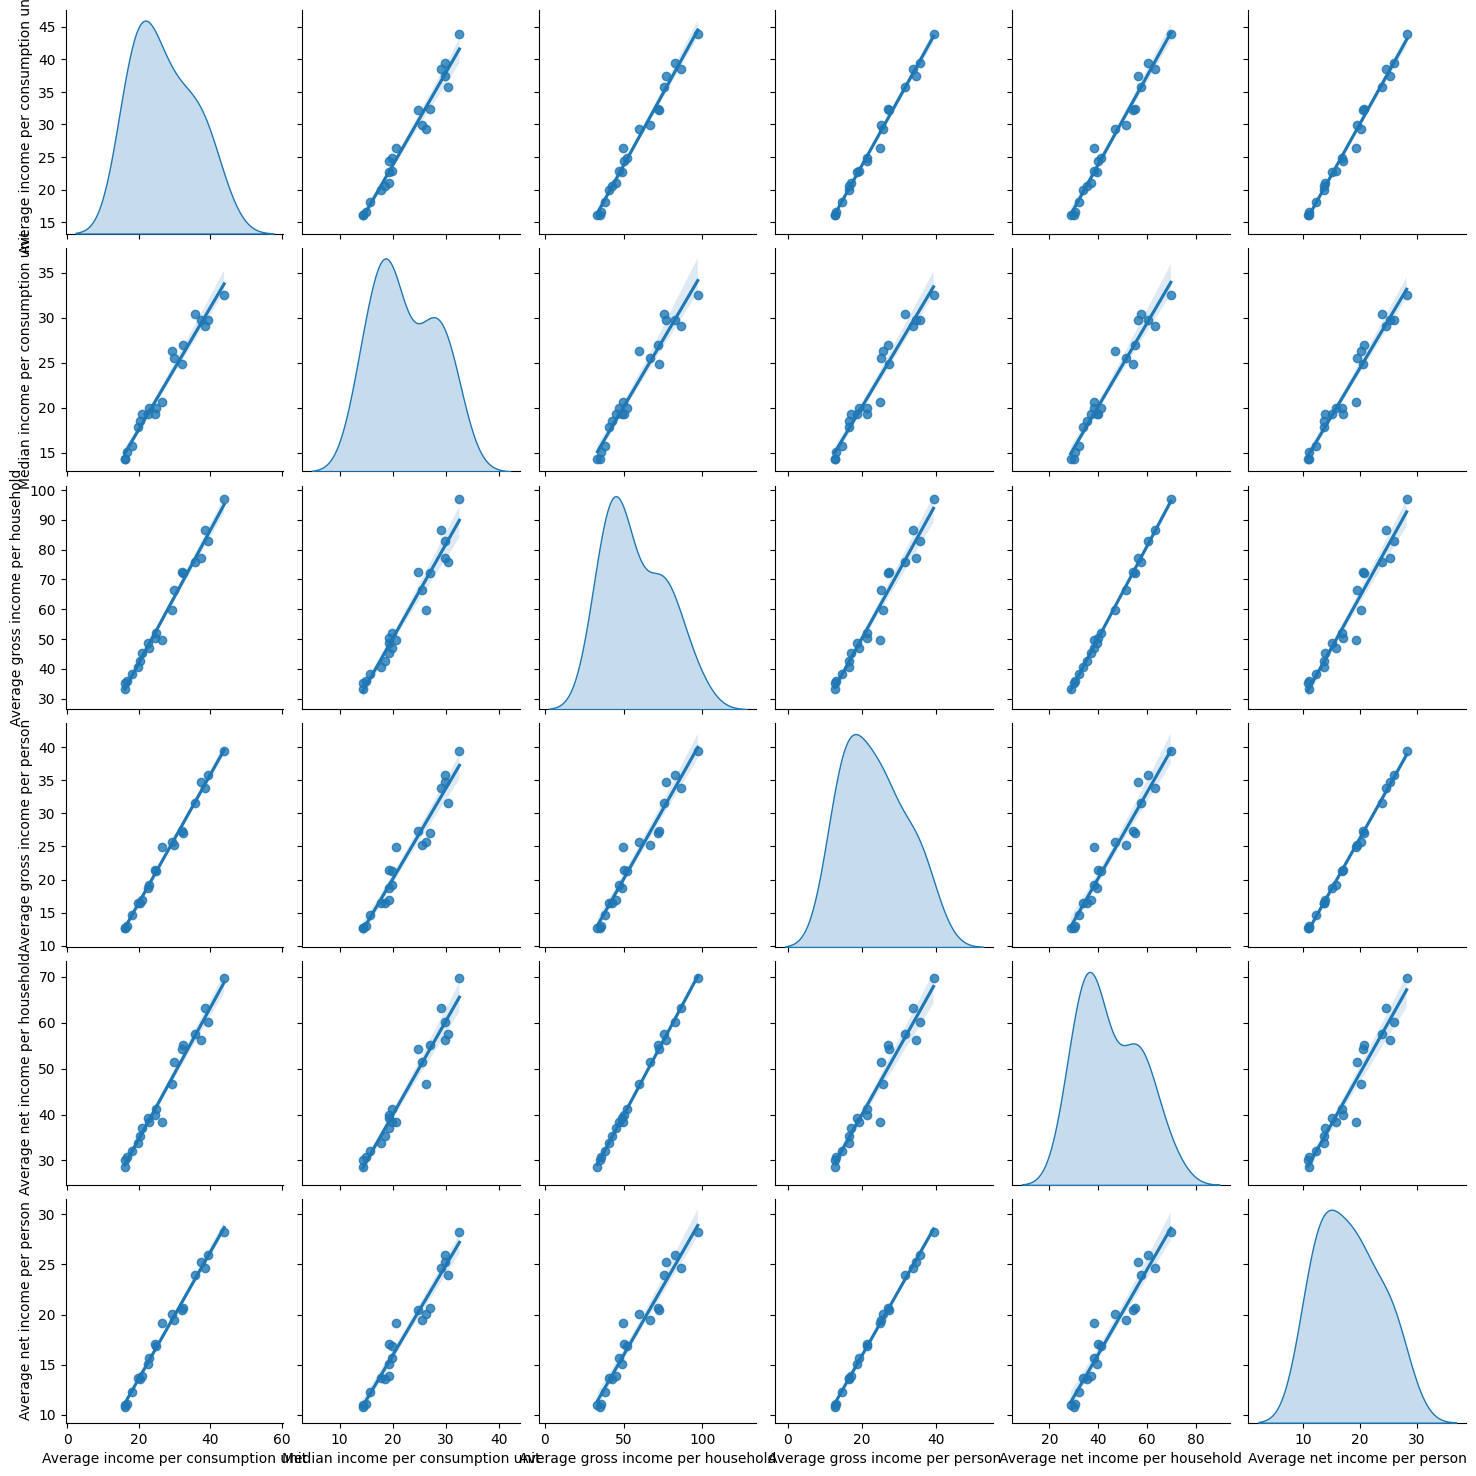

In [3]:
_ = sns.pairplot(
    gdf[cfg.INCOME_VARS_OF_INTEREST], kind="reg", diag_kind="kde"
)

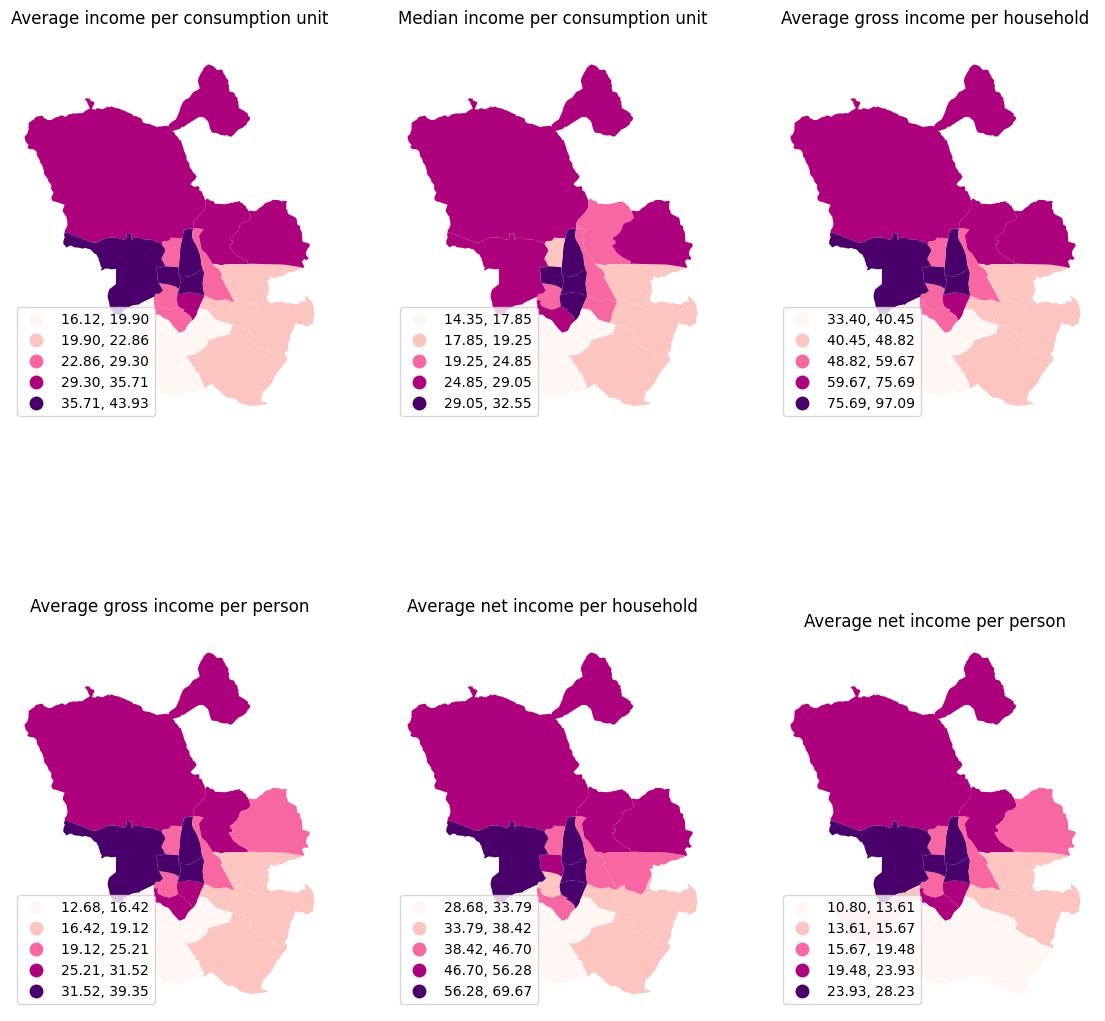

In [4]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 14))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cfg.INCOME_VARS_OF_INTEREST):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        k=5, # n quantiles
        legend=True,
        legend_kwds={"loc": "lower left"},
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

if cfg.SAVE_FIGURES:
    f.savefig(cfg.FIGURES_PATH / 'income_quantiles.png', dpi=300, bbox_inches='tight')

In [5]:
w = Queen.from_dataframe(gdf)

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_15615/38079147.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


In [6]:
# w = KNN.from_dataframe(gdf, k=4)

In [7]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(gdf[variable], w) for variable in cfg.INCOME_VARS_OF_INTEREST
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cfg.INCOME_VARS_OF_INTEREST, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
Average income per consumption unit,0.417235,0.001
Median income per consumption unit,0.314509,0.006
Average gross income per household,0.369917,0.001
Average gross income per person,0.452832,0.003
Average net income per household,0.358033,0.004
Average net income per person,0.459382,0.001


In [8]:
# CALCULATE GLOBAL MORAN'S I STATS FOR EACH VARIABLE OF INTEREST ---------------------------------------------------------------------------------------------
import numpy as np
np.random.seed(123456)

# Calculate Moran's I for each variable
global_mi = [
    Moran(gdf[variable], w) for variable in cfg.INCOME_VARS_OF_INTEREST
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim, res.z_sim)
    for variable, res in zip(cfg.INCOME_VARS_OF_INTEREST, global_mi)
]

global_moran = pd.DataFrame(
    mi_results, columns=["Variable", "Morans I", "P-value", "Z-Score"]
).set_index("Variable")

In [9]:

# CALCULATE LOCAL MORAN'S I STATS FOR EACH VARIABLE OF INTEREST ---------------------------------------------------------------------------------------------


local_mi = [
    Moran_Local(gdf[variable], w) for variable in cfg.INCOME_VARS_OF_INTEREST
]

mi_results_local = [
    (variable, res.Is, res.p_sim, res.z_sim, res.q)
    for variable, res in zip(cfg.INCOME_VARS_OF_INTEREST, local_mi)
]

local_moran = pd.DataFrame(
    mi_results_local, columns=["Variable", "Local Morans I","P-value", "Z-Score",  "Quadrant"]
).set_index("Variable")




In [10]:
local_moran

,Local Morans I,P-value,Z-Score,Quadrant
Variable,,,,
Average income per consumption unit,"[-0.05563024345796248, -0.15604025407240216, 0...","[0.017, 0.047, 0.371, 0.025, 0.016, 0.004, 0.0...","[-2.166379753200696, -1.6140719938038355, 0.31...","[2, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Median income per consumption unit,"[-0.24177333137168427, -0.3959099602765927, 0....","[0.018, 0.052, 0.361, 0.04, 0.049, 0.008, 0.04...","[-2.3295019297821673, -1.6078980630662598, 0.3...","[2, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Average gross income per household,"[-0.2790258145659181, -0.06974526333005861, -0...","[0.034, 0.028, 0.483, 0.064, 0.018, 0.002, 0.0...","[-1.8821903406448082, -1.9012700141484127, -0....","[2, 4, 4, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Average gross income per person,"[0.15453979721081815, -0.1596219343306181, 0.0...","[0.013, 0.06, 0.368, 0.018, 0.019, 0.002, 0.00...","[2.205300912839857, -1.5581241305500406, 0.321...","[1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."
Average net income per household,"[-0.3499393741220844, -0.10531364823997524, -0...","[0.027, 0.026, 0.479, 0.06, 0.017, 0.002, 0.01...","[-1.9009130546808677, -1.838220584778622, 0.03...","[2, 4, 4, 1, 1, 2, 1, 1, 4, 2, 3, 3, 3, 2, 2, ..."
Average net income per person,"[0.1696128806504696, -0.20765754351655485, 0.0...","[0.012, 0.074, 0.345, 0.016, 0.023, 0.002, 0.0...","[2.225276251950631, -1.5348159641319021, 0.430...","[1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 3, 2, 2, ..."


In [11]:
global_moran

,Morans I,P-value,Z-Score
Variable,,,
Average income per consumption unit,0.417235,0.001,3.813768
Median income per consumption unit,0.314509,0.006,2.755427
Average gross income per household,0.369917,0.001,3.441087
Average gross income per person,0.452832,0.003,3.955561
Average net income per household,0.358033,0.004,3.298673
Average net income per person,0.459382,0.001,4.017533


In [13]:
gdf['Median income per consumption unit']

0     20.65
1     26.25
2     30.45
3     29.75
4     32.55
5     19.25
6     29.75
7     26.95
8     29.05
9     17.85
10    15.75
11    14.35
12    14.35
13    19.95
14    19.95
15    24.85
16    15.05
17    18.55
18    19.25
19    19.25
20    25.55
Name: Median income per consumption unit, dtype: float64

In [14]:
moran_mc_r = [
    Moran(gdf[variable], w, permutations=1999) for variable in cfg.INCOME_VARS_OF_INTEREST
]

for variable, moran_mc in zip(cfg.INCOME_VARS_OF_INTEREST, moran_mc_r):
    print(f"Results for {variable}:")
    print(f"Moran's I: {moran_mc.I}")
    print(f"P-value: {moran_mc.p_sim}")
    print("-" * 40)

Results for Average income per consumption unit:
Moran's I: 0.41723477039892676
P-value: 0.0015
----------------------------------------
Results for Median income per consumption unit:
Moran's I: 0.31450934235692213
P-value: 0.0065
----------------------------------------
Results for Average gross income per household:
Moran's I: 0.3699172618508335
P-value: 0.003
----------------------------------------
Results for Average gross income per person:
Moran's I: 0.4528315259653595
P-value: 0.0005
----------------------------------------
Results for Average net income per household:
Moran's I: 0.3580327301096283
P-value: 0.0025
----------------------------------------
Results for Average net income per person:
Moran's I: 0.45938152328809306
P-value: 0.0005
----------------------------------------


/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/geopandas/array.py:334: UserWarning:

Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.

/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/geopandas/geodataframe.py:59: UserWarning:

Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.

/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/geopandas/geodataframe.py:407: UserWarning:

Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise 

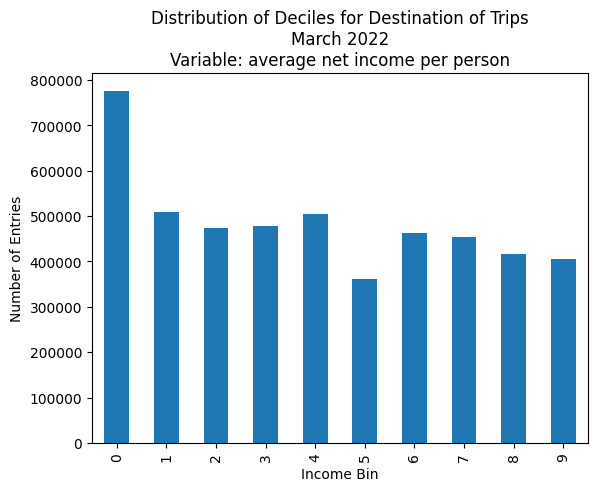

In [36]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import config as cfg
import pandas as pd
import geopandas as gpd
import sys
import logging
from scipy.stats import pearsonr
import numpy as np


# SET VARIABLES -----------------------------------------------------------------

# FIXME: Make more efficient, and fix variable names to plot nicely
var_of_interest = 'Average net income per person' 
n_income_deciles = 10
type_of_study='month'
if type_of_study == 'month':
    time_of_study = 'March 2022'
elif type_of_study == 'week':
    time_of_study = 'Normal Week'
else:
    print('No correct time of study has been set. Maybe you meant week or weekend?')



# FUNCTIONS -----------------------------------------------------------------------

def plot_assortativity_matrix(assortativity_matrix, name_of_figure, pearson=None, p_value=None, cmap='viridis', annot=True):
    """
    Plots the assortativity matrix of trips between deciles.
    Parameters:
    - assortativity_matrix (pd.DataFrame): The assortativity matrix to plot.
    - time_of_study (str): Description of the study period (e.g., "Normal Week").
    - var_of_interest (str): The variable of interest for the matrix (e.g., "Renta bruta media por hogar").
    - cmap (str): Color map to use for the heatmap.
    - save_fig (bool): Whether to save the figure to file.
    - fig_path (str or Path): Path to save the figure if save_fig is True.
    Returns:
    - None
    """
    title = f'Assortativity Matrix of Trips Between Deciles\n'
    title += f'{time_of_study}\nVariable: {var_of_interest.lower()}'
    if pearson is not None:
        title += f'\nPearson: {pearson:.4f}'
    if p_value is not None:
        title += f'\np-value: {p_value:.4f}'
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        assortativity_matrix, 
        annot=annot, 
        cmap=cmap, 
        cbar_kws={'label': 'Number of Trips'}, 
        fmt=".2f"
    )
    plt.title(title)
    plt.xlabel('Destination District SES')
    plt.ylabel('Home District SES')
    plt.show()

def calculate_assortativity_coefficient(normalized_matrix): 
    # FIXME: Review this procedure! it might be very wrong, I am unsure about the math behind it
    # Flatten the matrix and extract indices
    i_indices, j_indices = np.meshgrid(np.arange(normalized_matrix.shape[0]), 
                                    np.arange(normalized_matrix.shape[1]), 
                                    indexing='ij')

    # Flatten the matrix and indices
    i_indices_flat = i_indices.flatten()
    j_indices_flat = j_indices.flatten()
    matrix_flat = normalized_matrix.values.flatten()

    # Calculate Pearson correlation coefficient
    rho, p_value = pearsonr(i_indices_flat * j_indices_flat, matrix_flat)
    return matrix_flat, rho, p_value

# OPEN DATA ----------------------------------------------------------------------


rent_data = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') # rent data to add to the viajes data to find income per district
rent_data = rent_data[['ID', 'geometry'] + cfg.INCOME_VARS_OF_INTEREST ] # here I select the variables of interest

if type_of_study == 'month':
    file_name = 'all_viajes_month_0322.csv'
elif type_of_study == 'week':
    file_name = 'all_viajes_week_0222.csv'
else:
    file_name = 'default_file.csv'  # FIXME: Fallback option if neither is True

week = pd.read_csv(cfg.MOBILITY_DATA / f'VIAJES/all_viajes_month_0322.csv') # week of interest
week = week.loc[(week['actividad_origen'] == 'casa')] # filtering only trips from home!

# MERGE INCOME AND MOBILITY DATA ----------------------------------------------------------------------

# 1. Adding income data per district to the mobility data, to later calculate deciles and build assortativity matrix
viajes_with_income = pd.merge(
    week,
    rent_data,
    left_on='origen',  # The cleaned 'origen' from viajes DataFrame
    right_on='ID',  # The 'ID' from gdf
    how='left'  # Perform a left join to keep all rows from viajes
)



# CALCULATE INCOME DECILES ----------------------------------------------------------------------

# 2. Divide data into income deciles D for each SE class - for each origin and destination, I add the income decile 
rent_data['income_decile'] = pd.qcut(rent_data[var_of_interest], n_income_deciles, labels=False)

# Add deciles to dataframe
viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='origen', right_on='ID', how='left', suffixes=('', '_origin'))

viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='destino', right_on='ID', how='left', suffixes=('', '_dest'))
# Clean dataframe 
viajes_with_income.drop(columns=['residencia', 'estudio_origen_posible', 'estudio_origen_posible', 'ID', 'ID_origin', 'ID_dest'], inplace=True)

# PLOT INCOME DECILES -----------------------------------------------------------------------------------------------

bin_counts = viajes_with_income['income_decile'].value_counts().sort_index()
bin_counts.plot(kind='bar')

# 1. matplotlib. FIXME: IS this plot correct? I have to make sure it makes sense.
plt.xlabel('Income Bin')
plt.ylabel('Number of Entries')
plt.title(f'Distribution of Deciles for Destination of Trips\n{time_of_study}\nVariable: {var_of_interest.lower()}')

# 2. plotly
fig = px.bar(
    x=bin_counts.index,  # The 'Income Bin' values
    y=bin_counts.values,  # The 'Number of Entries' values
    labels={'x': 'Income Bin', 'y': 'Number of Entries'},
    title=f'Distribution of {var_of_interest} Deciles for Destination of Trips\n{time_of_study}'
)


# BUILD ASSORTATIVITY MATRICES ----------------------------------------------------------------------------------------

# Group by origin and destination deciles and count the trips
trip_counts_by_decile = viajes_with_income.groupby(['renta', 'income_decile', 'income_decile_dest']).size().reset_index(name='trip_count')
districts = rent_data['ID'].unique()

try:
    # Try using pivot() if there are no duplicate index/column combinations
    assortativity_matrix = trip_counts_by_decile.pivot(
        index='income_decile', 
        columns='income_decile_dest', 
        values='trip_count'
    ).fillna(0)

except ValueError as e:
    
    # Use pivot_table() with aggregation to handle duplicates
    assortativity_matrix = trip_counts_by_decile.pivot_table(
        index='income_decile', 
        columns='income_decile_dest', 
        values='trip_count', 
        aggfunc='sum',  # Aggregate duplicates by summing trip counts
        fill_value=0  # Fill missing values with 0
    )



# Normalize 
assortativity_matrix_normalized = assortativity_matrix.div(assortativity_matrix.sum(axis=1), axis=0)



In [39]:
r = calculate_assortativity_coefficient_from_formula(assortativity_matrix_normalized)

/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in sqrt



In [34]:
r

np.float64(1.3877787807814457e-17)

In [35]:
p

np.float64(1.0)

In [22]:
r

np.float64(0.42007927397075273)

In [23]:
p

np.float64(1.3549272643084433e-05)

In [48]:
week.renta.value_counts()

renta
>15      2814199
10-15    2024909
Name: count, dtype: int64

In [46]:
viajes_with_income[viajes_with_income['income_decile']==0].renta.value_counts()

renta
10-15    776251
Name: count, dtype: int64

In [53]:
assortativity_matrix

income_decile_dest,0,1,2,3,4,5,6,7,8,9
income_decile,,,,,,,,,,
0,202834,100312,49923,52536,48285,57848,75710,66960,60315,61528
1,102812,80123,59886,28390,32554,43286,45612,33873,40696,42651
2,47718,60711,64849,49180,35653,44840,37226,33773,55299,43977
3,45943,28965,48945,78266,58358,48146,38553,49420,33189,47594
4,28679,21378,24994,57749,68130,38736,41929,66947,67359,88319
5,22655,21372,21438,28621,24323,61596,49740,37398,54904,38385
6,50720,34482,24520,33013,43340,59783,66763,58916,42443,47897
7,40792,18747,16090,33874,54903,46774,54210,72714,55625,59948
8,18574,16177,31008,12836,52072,56449,27920,48752,95223,57263


In [54]:
assortativity_matrix_normalized

income_decile_dest,0,1,2,3,4,5,6,7,8,9
income_decile,,,,,,,,,,
0,0.261300,0.129226,0.064313,0.067679,0.062203,0.074522,0.097533,0.086261,0.077700,0.079263
1,0.201638,0.157140,0.117450,0.055679,0.063846,0.084894,0.089456,0.066433,0.079814,0.083649
2,0.100836,0.128292,0.137036,0.103925,0.075340,0.094754,0.078664,0.071368,0.116855,0.092930
3,0.096240,0.060675,0.102529,0.163949,0.122247,0.100855,0.080760,0.103524,0.069523,0.099699
4,0.056878,0.042398,0.049570,0.114531,0.135120,0.076824,0.083156,0.132773,0.133590,0.175160
5,0.062855,0.059296,0.059479,0.079407,0.067483,0.170895,0.138001,0.103759,0.152328,0.106497
6,0.109813,0.074656,0.053088,0.071476,0.093835,0.129435,0.144547,0.127558,0.091892,0.103701
7,0.089914,0.041322,0.035466,0.074665,0.121018,0.103100,0.119490,0.160277,0.122609,0.132138
8,0.044620,0.038861,0.074489,0.030835,0.125091,0.135605,0.067071,0.117115,0.228751,0.137561


In [57]:
from sklearn.preprocessing import normalize

#normalize matrix by rows
assortativity_matrix_normalized_2 = normalize(assortativity_matrix, axis=0, norm='l1')

In [58]:
assortativity_matrix_normalized_2

array([[0.35013275, 0.2532121 , 0.14118535, 0.13083042, 0.09937803,
        0.11738493, 0.16038861, 0.1283479 , 0.10797182, 0.10655251],
       [0.17747443, 0.20225011, 0.16936134, 0.07069962, 0.06700119,
        0.08783578, 0.0966272 , 0.06492725, 0.07285121, 0.07386184],
       [0.08237097, 0.15324946, 0.18339701, 0.12247297, 0.07337941,
        0.09098915, 0.07886179, 0.06473557, 0.09899251, 0.07615817],
       [0.07930696, 0.07311477, 0.13841951, 0.19490584, 0.12010982,
        0.09769767, 0.08167299, 0.0947275 , 0.05941269, 0.08242199],
       [0.04950579, 0.05396332, 0.07068459, 0.14381235, 0.14022212,
        0.07860294, 0.08882491, 0.12832299, 0.12058151, 0.15294843],
       [0.03910714, 0.05394817, 0.060628  , 0.07127488, 0.05006051,
        0.12499036, 0.1053722 , 0.07168391, 0.09828541, 0.06647409],
       [0.08755304, 0.08704103, 0.06934409, 0.08221228, 0.08920045,
        0.12131143, 0.14143475, 0.11292929, 0.07597858, 0.08294672],
       [0.07041529, 0.04732203, 0.0455035

In [60]:
min_val = assortativity_matrix.min().min()  # Find the minimum value in the entire DataFrame
max_val = assortativity_matrix.max().max()  # Find the maximum value in the entire DataFrame

# Apply min-max normalization
df_normalized = (assortativity_matrix - min_val) / (max_val - min_val)

In [61]:
df_normalized

income_decile_dest,0,1,2,3,4,5,6,7,8,9
income_decile,,,,,,,,,,
0,1.000000,0.462921,0.198949,0.212638,0.190368,0.240466,0.334039,0.288200,0.253389,0.259744
1,0.476017,0.357157,0.251142,0.086145,0.107959,0.164180,0.176365,0.114868,0.150612,0.160853
2,0.187398,0.255464,0.277142,0.195057,0.124193,0.172321,0.132434,0.114345,0.227112,0.167800
3,0.178099,0.089157,0.193826,0.347429,0.243137,0.189640,0.139385,0.196314,0.111285,0.186748
4,0.087659,0.049411,0.068354,0.239947,0.294330,0.140344,0.157071,0.288132,0.290291,0.400093
5,0.056101,0.049380,0.049725,0.087355,0.064839,0.260100,0.197990,0.133335,0.225043,0.138505
6,0.203124,0.118059,0.065871,0.110363,0.164463,0.250602,0.287168,0.246061,0.159764,0.188336
7,0.151115,0.035628,0.021709,0.114874,0.225038,0.182453,0.221407,0.318344,0.228820,0.251467
8,0.034722,0.022165,0.099860,0.004662,0.210207,0.233137,0.083683,0.192815,0.436261,0.237401


In [13]:
import config as cfg
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
gdf = gpd.read_file('data/processed/geometries_and_income.geojson')
income_array = gdf['Average income per consumption unit'].to_numpy()
income_data_sorted = np.sort(income_array)

/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/geopandas/geodataframe.py:59: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  data.array.crs = crs
/Users/caro/Desktop/thesis_project/.thesis_env/lib/python3.11/site-packages/geopandas/geodataframe.py:407: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The fun

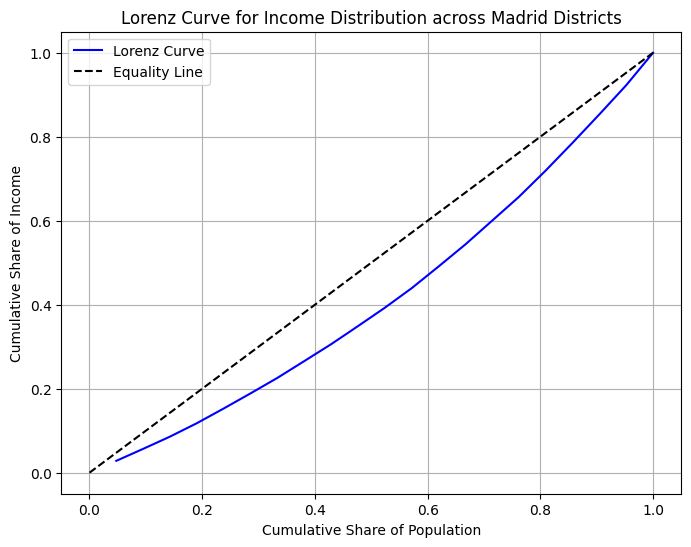

In [17]:
import matplotlib.pyplot as plt
# Calculate the cumulative income share
cumulative_income = np.cumsum(income_data_sorted) / income_data_sorted.sum()

# Generate cumulative population share (since 21 districts, each represents 1/21 of the population)
cumulative_population = np.arange(1, len(income_data_sorted) + 1) / len(income_data_sorted)

# Plot the Lorenz curve
plt.figure(figsize=(8, 6))
plt.plot(cumulative_population, cumulative_income, label='Lorenz Curve', color='blue')
plt.plot([0, 1], [0, 1], label='Equality Line', color='black', linestyle='--')

plt.title('Lorenz Curve for Income Distribution across Madrid Districts')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Income')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import config as cfg
import pandas as pd 
import geopandas as gpd

def remove_thousands_separator(value):
    # Remove dots and convert to integer
    return int(value.replace('.', ''))

nombres_distritos = pd.read_csv(cfg.ZONIFICACION_DATA / 'distritos/PROCESSED_nombres_distritos.csv')
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson')
renta = pd.read_csv(
    'data/raw/indicadores_renta_2_2021.csv', 
    sep=';', 
    converters={
        'Total': remove_thousands_separator,
    }
)# SOURCE = https://ine.es/jaxiT3/Datos.htm?t=31097
gini_index = pd.read_csv('data/raw/gini_index_madrid.csv', sep='\t')

renta['ID'] = renta['Distritos'].str[:7]
renta.drop(columns=['Distritos', 'Municipios', 'Secciones'], inplace=True)

In [7]:

renta_pivot = renta.pivot(index='ID', columns='Indicadores de renta media y mediana', values='Total').reset_index()
renta_pivot.columns.name = None  # Remove the column grouping label
renta_pivot['ID'] = renta_pivot['ID'].astype('int64')
gdf['ID'] = gdf['ID'].astype('int64')

merged = pd.merge(renta_pivot, gdf, on='ID', how='inner') # merging the income and geography data into one gdf
merged = gpd.GeoDataFrame(merged, geometry='geometry')
#merged = merged.set_crs(gdf.crs)

merged = merged.rename(columns={ # translating
    'Media de la renta por unidad de consumo': 'Average income per consumption unit',
    'Mediana de la renta por unidad de consumo': 'Median income per consumption unit',
    'Renta bruta media por hogar': 'Average gross income per household',
    'Renta bruta media por persona': 'Average gross income per person',
    'Renta neta media por hogar': 'Average net income per household',
    'Renta neta media por persona ': 'Average net income per person'
})

gini_index['ID'] = gini_index['Distritos'].str[:7]
gini_index.drop(columns=['Distritos', 'Sections', 'Municipalities', 'Gini Index and Income Distribution P80/P20', 'Period'], inplace=True)
gini_index['ID'] = gini_index['ID'].astype('int64')

merged_2 = pd.merge(gini_index, merged, on='ID')
merged_2.rename(columns={'Total': 'Gini Index'}, inplace=True)
merged_2 = gpd.GeoDataFrame(merged_2, geometry='geometry')
#merged_2 = merged_2.set_crs(gdf.crs)


# NOTE: This code fixes issues with integers and decimals, but it is a last addition and might not work. Remove if needed
#merged_2['Gini Index'] = merged_2['Gini Index'].astype(float)

# Convert the rest of the specified columns to integers
#columns_to_fix = ['Average income per consumption unit', 'Average gross income per household',
                  #'Average gross income per person', 'Average net income per household',
                  #'Average net income per person', 'Median income per consumption unit']

#for col in columns_to_fix:
#    merged_2[col] = merged_2[col].astype(str).str.replace('.', '').astype(int)

# merged.to_file("segregation_indices/data/processed/geometries_and_income.geojson", driver="GeoJSON")
merged_2.to_file("data/processed/geometries_and_income.geojson", driver="GeoJSON")

In [8]:
merged_2.crs

<Projected CRS: EPSG:3042>
Name: ETRS89 / UTM zone 30N (N-E)
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
merged_2['Average income per consumption unit'].max()

43930